In [21]:
import numpy as np
import pandas as pd
import re
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras import utils
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
def remove_stopwords(input_text):

    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [12]:
train_df = pd.read_csv("/content/Tweets.csv")
train_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
Mood = train_df['airline_sentiment'].value_counts()

Text(0.5, 1.0, 'Mood Distribution')

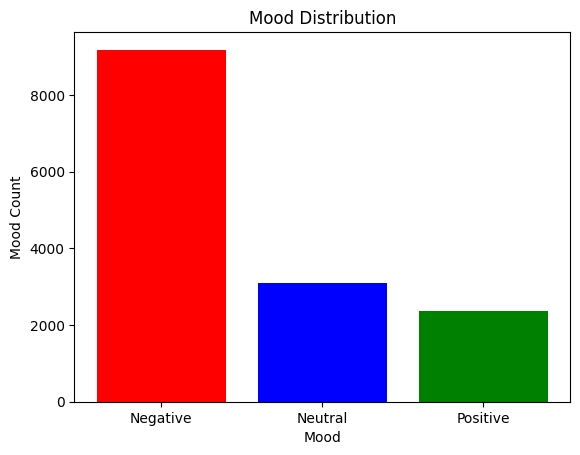

In [14]:
index = [1,2,3]
plt.bar(index,Mood,color=['r','b','g'])
plt.xticks(index,['Negative','Neutral','Positive'])
plt.xlabel('Mood')
plt.ylabel('Mood Count')
plt.title('Mood Distribution')

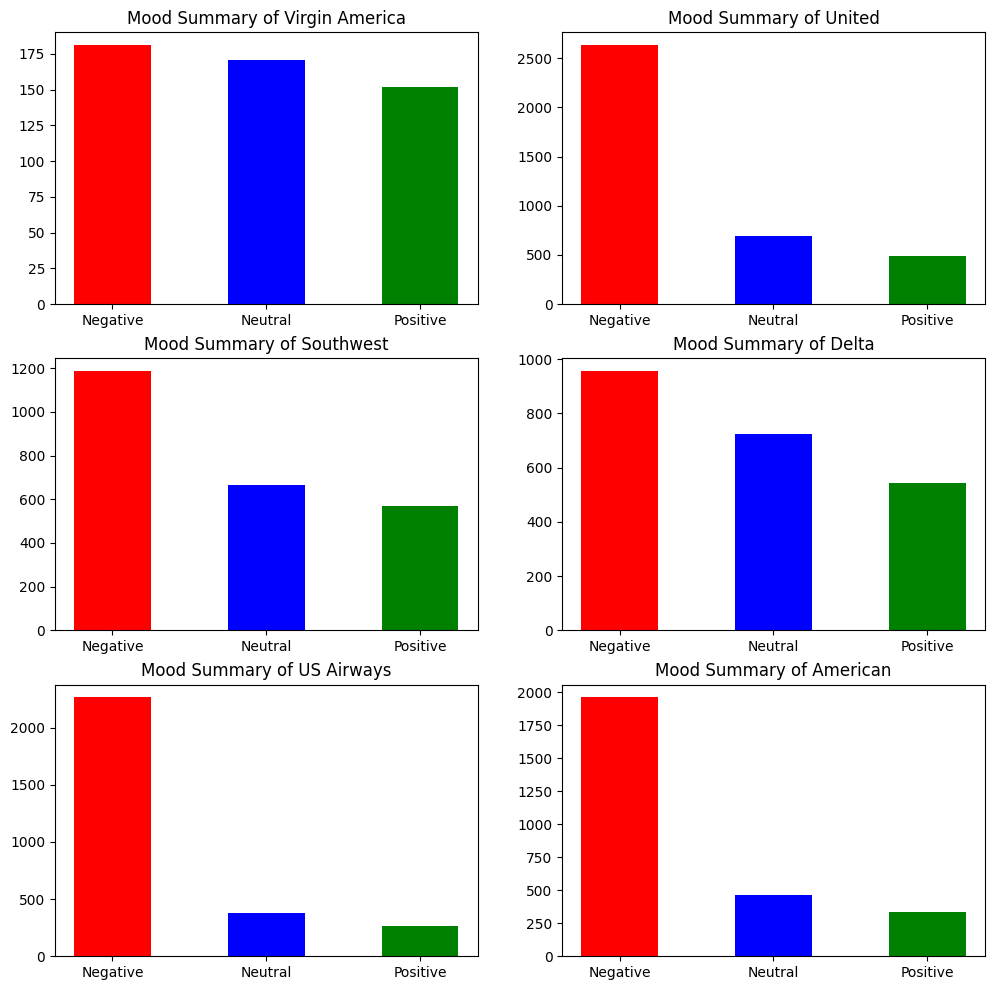

In [15]:
def plot_sub_sentiment(Airline):
    pdf = train_df[train_df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color = ['red','blue','green']
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Mood Summary of' + " " + Airline)

airline_name = train_df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])
plt.show()

In [16]:
train_df = train_df[['text', 'airline_sentiment']]
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})
train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

<ipython-input-16-8359d24b1248>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.text = train_df.text.apply(remove_mentions)
<ipython-input-16-8359d24b1248>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})


,text,sentiment
0,What said.,1
1,plus you've added commercials to the experien...,2
2,I didn't today... Must mean I need to take an...,1
3,"it's really aggressive to blast obnoxious ""en...",0
4,and it's a really big bad thing about it,0


In [17]:
raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values

maxLen = len(max(raw_docs_train, key=len).split())

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train,
                                                  stratify=sentiment_train,
                                                  random_state=42,
                                                  test_size=0.1, shuffle=True)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (13176,)
# Test data samples: (1464,)


In [22]:
num_labels = len(np.unique(sentiment_train))
Y_oh_train = utils.to_categorical(Y_train, num_labels)
Y_oh_test = utils.to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(13176, 3)


In [23]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/glove.6B.50d.txt')

In [37]:
word = "amazing"
index = 281246
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of amazing in the vocabulary is 53201
the 281246th word in the vocabulary is perennial


In [25]:
def sentences_to_indices(X, word_to_index, max_len):

    m = X.shape[0]

    X_indices = np.zeros((m,max_len))

    for i in range(m):

        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']

        j = 0

        for w in sentence_words:
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            j = j+1

    return X_indices

In [26]:
# Create Keras Embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):

    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]

    emb_matrix = np.zeros((vocab_len,emb_dim))

    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))

    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [27]:

def ltsm_model(input_shape, word_to_vec_map, word_to_index):

    sentence_indices =  Input(shape=input_shape, dtype='int32')

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    embeddings = embedding_layer(sentence_indices)

    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(3, activation=None)(X)
    X = Activation('softmax')(X)

    model = Model(inputs=[sentence_indices], outputs=X)

    return model

In [28]:
model = ltsm_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 26)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 26, 50)              │      20,000,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 26, 128)             │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,223,669 (77.15 MB)

 Trainable params: 223,619 (873.51 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)

(13176, 26)


In [31]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=20,
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 26))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.5769 - loss: 0.9132 - val_accuracy: 0.6318 - val_loss: 0.8198
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.6525 - loss: 0.8059 - val_accuracy: 0.7138 - val_loss: 0.7127
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 0.7100 - loss: 0.7146 - val_accuracy: 0.7329 - val_loss: 0.6742
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.7269 - loss: 0.6797 - val_accuracy: 0.7459 - val_loss: 0.6482
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accuracy: 0.7352 - loss: 0.6570 - val_accuracy: 0.7391 - val_loss: 0.6405
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - accuracy: 0.7393 - loss: 0.6347 - val_accuracy: 0.7425 - val_loss: 0.6477
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.7456 - loss: 0.6281 - val_accuracy: 0.7555 - val_loss: 0.6183
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 0.7507 - loss: 0.6203 - val_accuracy: 0.752

In [35]:
x_test = np.array([
    "This is a great product!",
    "I am very happy with this purchase.",
    "I love this company!",
    "This is the best thing ever.",
    "I highly recommend this.",
    "This is a fantastic experience.",
    "I am very satisfied.",
    "This is truly wonderful.",
    "I am delighted with this.",
    "I am thrilled with this.",
    "I am very pleased.",
    "This is truly remarkable.",

    "This is a terrible product.",
    "I am very unhappy with this purchase.",
    "The service was awful.",
    "I hate this company!",
    "This is the worst thing ever.",
    "I do not recommend this.",
    "This is horrible.",
    "I am so disappointed.",
    "This is terrible.",
    "This is a dreadful experience.",
    "I am very dissatisfied.",

    "This is appalling.",
    "This is subpar.",
    "I am frustrated with this.",
    "This is dreadful.",
    "I am very displeased.",
    "This is unacceptable.",

    "I am neutral about this purchase.",
    "I would not necessarily recommend this.",
    "I am reasonably satisfied.",
    "This is just okay.",
    "This is a so-so experience.",
    "This is unremarkable.",
    "I have no opinion on this.",
    "This is nothing special.",
    "This is average.",
    "I am neither thrilled nor frustrated.",
    "This is adequate.",
    "I am neither pleased nor displeased.",
    "This is passable.",
    "This is nothing to write home about.",

    "This could be better.",
    "I have some concerns about this purchase.",
    "The service was below average.",
    "I am not a fan of this company.",
    "This is somewhat disappointing.",
    "This is subpar.",
    "I am not very impressed.",
    "This is not great.",
    "This is a lackluster experience.",
    "I am not entirely satisfied.",
    "This is underwhelming.",
    "I am not sure about this.",
    "This is not very good.",
    "This is below average.",
    "I am not very thrilled.",
    "This is mediocre.",
    "I am not very pleased.",
    "This is not ideal.",
    "This is not very remarkable.",

    "This has potential.",
    "I am cautiously optimistic about this purchase.",
    "The service was decent.",
    "I am willing to give this company a chance.",
    "This is not bad.",
    "I am open to this.",
    "This is promising.",
    "I am somewhat impressed.",
    "This is better than expected.",
    "This is a decent experience.",
    "This is encouraging.",
    "I am hopeful about this.",
    "This is not terrible.",
    "This is above average.",
    "I am somewhat thrilled.",
    "This is good enough.",
    "I am somewhat pleased.",
    "This is acceptable.",
    "This is not too shabby."
])

In [36]:
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)

predictions = model.predict(X_test_indices)

sentiment_labels = ['negative', 'neutral', 'positive']

for i, prediction in enumerate(predictions):
  sentiment_index = np.argmax(prediction)
  sentiment_label = sentiment_labels[sentiment_index]
  sentiment_score = prediction[sentiment_index]

  print(f"Statement: {x_test[i]}")
  print(f"Sentiment: {sentiment_label}")
  print(f"Score: {sentiment_score}")
  print("-" * 20)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Statement: This is a great product!
Sentiment: positive
Score: 0.9357349872589111
--------------------
Statement: I am very happy with this purchase.
Sentiment: positive
Score: 0.8550944328308105
--------------------
Statement: I love this company!
Sentiment: positive
Score: 0.9055367708206177
--------------------
Statement: This is the best thing ever.
Sentiment: positive
Score: 0.876365065574646
--------------------
Statement: I highly recommend this.
Sentiment: positive
Score: 0.3631272614002228
--------------------
Statement: This is a fantastic experience.
Sentiment: positive
Score: 0.9332467913627625
--------------------
Statement: I am very satisfied.
Sentiment: positive
Score: 0.47896820306777954
--------------------
Statement: This is truly wonderful.
Sentiment: positive
Score: 0.7789579629898071
--------------------
Statement: I am delighted with this.
Sentiment: positive
Score: 0.7649223208427429
--------------------
Statement: I am thri